### Exploração: Criação de regras financeiras para definição de risco de credito

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix


In [2]:
df_credit = pd.read_csv('corporating_credit_data/corporate_rating_train.csv')
df_credit.head(2)

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,BBB,RPM International Inc.,RPM,Egan-Jones Ratings Company,8/20/2015,Basic Industries,2.324803,1.252078,0.193428,75.963264,...,-57.510867,0.741675,1.886241,1.344624,3.635023,-0.000851,23.162414,2.543218,0.071922,5.180325
1,A,Broadcom Inc.,AVGO,Moody's Investors Service,6/15/2012,Technology,3.980000,3.305714,2.368571,51.250000,...,0.016043,0.845730,2.501165,3.376980,1.219342,0.241866,10.002166,2.957403,0.310788,5.380090


In [3]:
rating_dict = {'AAA': 0,
             'AA': 1,
             'A': 2,
             'BBB': 3,
             'BB': 4,
             'B': 5,
             'CCC': 6,
             'CC': 7,
             'C': 8,
             'D': 9}

# According to Standard & Poor's (S&P)
# S&P Global is a services company that creates financial indices and provides credit ratings
risk_dict = {'AAA': 'Lowest Risk',
             'AA': 'Low Risk',
             'A': 'Low Risk',
             'BBB': 'Medium Risk',
             'BB': 'High Risk',
             'B': 'High Risk',
             'CCC': 'Highest Risk',
             'CC': 'Highest Risk',
             'C': 'Highest Risk',
             'D': 'Highest Risk'}

In [4]:
# Map the 'Rating' column to the new 'Rating_id' column using the rating_dict
df_credit["Rating_id"] = df_credit["Rating"].map(rating_dict)

In [5]:
# CHAT GPT: NECESSARIO CHECKAR
# Agrupamento por blocos financeiros
# Baseado em Damodaran / CFA Institute:

# Liquidez
df_credit["liquidity_score"] = (
    0.4 * df_credit["currentRatio"] +
    0.3 * df_credit["quickRatio"] +
    0.3 * df_credit["cashRatio"]
)

# Rentabilidade
df_credit["profitability_score"] = (
    0.25 * df_credit["grossProfitMargin"] +
    0.25 * df_credit["operatingProfitMargin"] +
    0.25 * df_credit["netProfitMargin"] +
    0.25 * df_credit["returnOnAssets"]
)

# Endividamento
df_credit["leverage_score"] = (
    0.6 * df_credit["debtRatio"] +
    0.4 * df_credit["debtEquityRatio"]
)

# Fluxo de Caixa
df_credit["cashflow_score"] = (
    0.5 * df_credit["operatingCashFlowPerShare"] +
    0.5 * df_credit["freeCashFlowPerShare"]
)

In [6]:
# Normalização dos scores para garantir que estejam na mesma escala

score_cols = [
    "liquidity_score",
    "profitability_score",
    "leverage_score",
    "cashflow_score"
]

scaler = StandardScaler()
df_credit[score_cols] = scaler.fit_transform(df_credit[score_cols])


In [7]:
# Cálculo do score financeiro final com pesos personalizados

df_credit["financial_health_score"] = (
    0.3 * df_credit["liquidity_score"] +
    0.3 * df_credit["profitability_score"] -
    0.2 * df_credit["leverage_score"] +
    0.2 * df_credit["cashflow_score"]
)

In [8]:
# Classificação de risco com base no score financeiro e na classificação de crédito
df_credit["high_risk"] = (df_credit["Rating_id"] >= 5).astype(int)
features = score_cols + ["financial_health_score"]

# Classificação bnaria: 1 para alto risco (Rating_id >= 5), 0 para baixo risco (Rating_id < 5)
X = df_credit[features]
y = df_credit["high_risk"]


In [9]:
# Divisão dos dados em treino e teste e treinamento do modelo XGBoost

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = XGBClassifier(n_estimators=100, booster='gbtree', objective='binary:logistic')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [10]:
y_pred = model.predict(X_test)

In [11]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8153846153846154
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       265
           1       0.50      0.33      0.40        60

    accuracy                           0.82       325
   macro avg       0.68      0.63      0.65       325
weighted avg       0.79      0.82      0.80       325



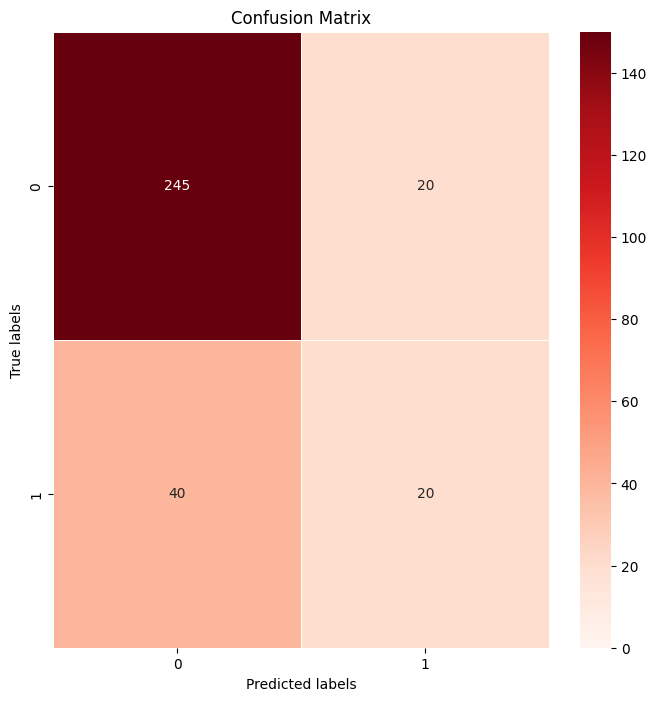

In [12]:
# Create a confusion matrix and display it with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(cm, annot = True, ax = ax, vmin=0, vmax=150, fmt="d", linewidths=.5, linecolor = 'white', cmap="Reds") # annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [13]:
df_credit["risk_probability"] = model.predict_proba(X)[:, 1]


In [14]:
def rule_based_risk(row):
    flags = 0

    if row["currentRatio"] < 1:
        flags += 1
    if row["debtRatio"] > 0.6:
        flags += 1
    if row["returnOnAssets"] < 0:
        flags += 1
    if row["operatingCashFlowPerShare"] < 0:
        flags += 1

    return flags

df_credit["rule_flags"] = df_credit.apply(rule_based_risk, axis=1)


In [15]:
df_credit["final_risk_score"] = (
    0.7 * df_credit["risk_probability"] +
    0.3 * (df_credit["rule_flags"] / df_credit["rule_flags"].max())
)


In [16]:
df_credit["risk_bucket"] = pd.cut(
    df_credit["final_risk_score"],
    bins=[0, 0.33, 0.66, 1],
    labels=["Low", "Medium", "High"]
)


In [17]:
# Create dataframe to compare rating rule flags final risk score rsc bucket and model probability
df_comparison = pd.DataFrame({
    "Name": df_credit["Name"],
    "Rating": df_credit["Rating"],
    "Financial Health Score": df_credit["financial_health_score"],
    "Risk Probability": df_credit["risk_probability"],
    "Rule Flags": df_credit["rule_flags"],
    "Final Risk Score": df_credit["final_risk_score"],
    "Risk Bucket": df_credit["risk_bucket"],
})

In [18]:
df_comparison.head(5)

,Name,Rating,Financial Health Score,Risk Probability,Rule Flags,Final Risk Score,Risk Bucket
0,RPM International Inc.,BBB,-0.014070,0.015124,1,0.085587,Low
1,Broadcom Inc.,A,0.018321,0.000962,0,0.000673,Low
2,Tenneco Inc.,BBB,-0.033261,0.018591,1,0.088014,Low
3,Dover Corporation,A,-0.016657,0.000787,0,0.000551,Low
4,Briggs & Stratton Corporation,BB,-0.005038,0.009676,0,0.006773,Low


In [19]:
df_comparison[df_comparison['Rating'] == 'C']

,Name,Rating,Financial Health Score,Risk Probability,Rule Flags,Final Risk Score,Risk Bucket
245,Caesars Entertainment Corporation,C,-0.040044,0.880041,2,0.766028,High
313,Cleveland-Cliffs Inc.,C,-0.013241,0.975212,2,0.832649,High
